In [6]:
!pip -q install faiss-cpu sentence-transformers transformers datasets psutil

In [8]:
import os, re, json, time, random, gc, psutil
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

import torch
from sentence_transformers import SentenceTransformer
import faiss

# --------------------------- Config ---------------------------
CHUNKS_JSONL = "/content/chunks_fixed_s512_o64.jsonl"   # change if needed
RESULTS_CSV  = "/content/embeddings_ablation_results.csv"
INDEX_DIR    = "/content/indexes"
os.makedirs(INDEX_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [9]:
# --------------------------- Utils ----------------------------
def read_jsonl(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return rows

def mrr_at_k(gt_lists, retrieved, k=10):
    mrr = 0.0
    for i in range(len(gt_lists)):
        rr = 0.0
        for rank, rid in enumerate(retrieved[i][:k], 1):
            if rid in gt_lists[i]:
                rr = 1.0/rank; break
        mrr += rr
    return mrr/len(gt_lists)

def recall_at_k(gt_lists, retrieved, k=5):
    r = 0.0
    for i in range(len(gt_lists)):
        rel = gt_lists[i]
        denom = max(1,len(rel))
        got = len(set(retrieved[i][:k]) & rel)
        r += got/denom
    return r/len(gt_lists)

def latency_stats(latencies):
    arr = np.array(latencies)*1000
    return round(np.median(arr),2), round(np.percentile(arr,95),2)

def save_faiss_index(index, path):
    faiss.write_index(index, path)
    return round(Path(path).stat().st_size / (1024*1024), 2)

In [10]:
# --------------------------- Load chunks ----------------------
chunks = read_jsonl(CHUNKS_JSONL)
texts = [c["text"] for c in chunks if c.get("text")]
print("Chunks loaded:", len(texts))

Chunks loaded: 100


In [15]:
# --------------------------- Eval Queries ---------------------
eval_queries = [
    "How do I onboard as a merchant?",
    "Steps for KYC verification?",
    "How are refunds processed?",
    "What security features does JioPay have?",
    "Pricing model for transactions?",
    "How to integrate with API?",
    "Payment dispute resolution?",
    "Settlement timelines for merchants?",
    "Is there support for UPI?",
    "How to handle chargebacks?"
]
# For now treat each query as having at least one relevant chunk (approx evaluation)
gt_sets = [set([i]) for i in range(len(eval_queries))]

# --------------------------- Models ---------------------------
MODELS = [
    "sentence-transformers/all-MiniLM-L6-v2",  # 384d
    "intfloat/e5-base-v2",                     # 768d
    "BAAI/bge-small-en-v1.5"                   # 384d
]

In [20]:
import math
import numpy as np
import faiss

def _pick_nlist(N: int) -> int:
    # sqrt rule, clamped; also cannot exceed N
    if N < 50:
        return max(8, min(N, 16))
    nlist = int(np.sqrt(N))
    nlist = int(np.clip(nlist, 16, 4096))
    return min(nlist, N)

def _pick_ntrain(N: int, nlist: int) -> int:
    # >= nlist, prefer ~10*nlist but never exceed N
    return min(N, max(nlist, 10 * nlist))

def _pick_nbits(ntrain: int, default_nbits: int = 8) -> int:
    # Ensure 2^nbits <= ntrain. If not, shrink nbits.
    max_nbits = int(math.floor(math.log2(max(2, ntrain))))
    return max(4, min(default_nbits, max_nbits))  # don't go below 4 for stability

def _pick_m(dim: int, default_m: int = 16) -> int:
    # m must divide dim. If not, choose the largest divisor <= default_m, else any divisor.
    if dim % default_m == 0:
        return default_m
    for m in range(min(default_m, dim), 1, -1):
        if dim % m == 0:
            return m
    return 1

def build_index_flatIP(dim: int, xb: np.ndarray):
    index = faiss.IndexFlatIP(dim)
    index.add(xb)
    return index, {"note": "flat"}

def build_index_hnsw(dim: int, xb: np.ndarray, M=32, efSearch=64):
    index = faiss.IndexHNSWFlat(dim, M)
    index.hnsw.efSearch = efSearch
    index.add(xb)
    return index, {"M": M, "efSearch": efSearch}

def build_index_ivf(dim: int, xb: np.ndarray):
    N = len(xb)
    nlist = _pick_nlist(N)
    if N < max(50, nlist):
        return None, {"note": "too_small_fallback_to_flat", "nlist": nlist}
    quant = faiss.IndexFlatIP(dim)
    index = faiss.IndexIVFFlat(quant, dim, nlist, faiss.METRIC_INNER_PRODUCT)
    ntrain = _pick_ntrain(N, nlist)
    train = xb[np.random.choice(N, size=ntrain, replace=False)]
    index.train(train)
    index.add(xb)
    index.nprobe = min(8, nlist)
    return index, {"nlist": nlist, "ntrain": ntrain, "nprobe": index.nprobe}

def build_index_ivfpq(dim: int, xb: np.ndarray, default_m=16, default_nbits=8):
    N = len(xb)
    nlist = _pick_nlist(N)
    if N < max(50, nlist):
        return None, {"note": "too_small_fallback_to_flat", "nlist": nlist}
    quant = faiss.IndexFlatIP(dim)
    ntrain = _pick_ntrain(N, nlist)
    # PQ constraints: need 2^nbits <= ntrain
    nbits = _pick_nbits(ntrain, default_nbits)
    m = _pick_m(dim, default_m)
    index = faiss.IndexIVFPQ(quant, dim, nlist, m, nbits, faiss.METRIC_INNER_PRODUCT)
    train = xb[np.random.choice(N, size=ntrain, replace=False)]
    index.train(train)  # will succeed because 2^nbits <= ntrain
    index.add(xb)
    index.nprobe = min(8, nlist)
    return index, {"nlist": nlist, "ntrain": ntrain, "m": m, "nbits": nbits, "nprobe": index.nprobe}

In [21]:
# --------------------------- Ablation -------------------------
records = []
for mname in MODELS:
    print("\n==== Model:", mname, "====")
    model = SentenceTransformer(mname, device=device)
    dim = model.get_sentence_embedding_dimension()

    # ---- Embedding Corpus ----
    t0 = time.time()
    xb = model.encode(texts, batch_size=128, convert_to_numpy=True,
                      show_progress_bar=True, normalize_embeddings=True).astype("float32")
    emb_time = time.time()-t0
    mem_mb = psutil.virtual_memory().used/(1024*1024)

    # ---- Embedding Queries ----
    xq = model.encode(eval_queries, batch_size=32, convert_to_numpy=True,
                      show_progress_bar=False, normalize_embeddings=True).astype("float32")

    for itype in ["flat","ivf","ivfpq","hnsw"]:
      t0 = time.time()
      extra = {}
      try:
          if itype == "flat":
              index, extra = build_index_flatIP(dim, xb)
          elif itype == "ivf":
              index, extra = build_index_ivf(dim, xb)
              if index is None:
                  itype = "flat"; index, extra = build_index_flatIP(dim, xb)
          elif itype == "ivfpq":
              index, extra = build_index_ivfpq(dim, xb, default_m=16, default_nbits=8)
              if index is None:
                  itype = "flat"; index, extra = build_index_flatIP(dim, xb)
          else:  # hnsw
              index, extra = build_index_hnsw(dim, xb, M=32, efSearch=64)
      except Exception as e:
          # Last-resort fallback
          itype = "flat"; index, extra = build_index_flatIP(dim, xb)
          extra["fallback_error"] = str(e)

      build_time = time.time() - t0
      idx_path = f"{INDEX_DIR}/{Path(mname).name}_{itype}.faiss"
      faiss.write_index(index, idx_path)
      idx_size = round(Path(idx_path).stat().st_size / (1024*1024), 2)

      # ---- retrieval & metrics (same as before) ----
      latencies=[]; retrieved=[]
      for q in xq:
          qv = np.expand_dims(q,0)
          t0 = time.time()
          D,I = index.search(qv, 10)
          latencies.append(time.time()-t0)
          retrieved.append(I[0].tolist())

      p1  = sum([1 if gt_sets[i] & set(retrieved[i][:1]) else 0 for i in range(len(eval_queries))]) / len(eval_queries)
      rec5  = recall_at_k(gt_sets, retrieved, k=5)
      rec10 = recall_at_k(gt_sets, retrieved, k=10)
      mrrv  = mrr_at_k(gt_sets, retrieved, k=10)
      p50,p95 = latency_stats(latencies)

      records.append({
          "model": mname, "dim": dim, "index": itype,
          "extra": extra,
          "emb_time_s": round(emb_time,2),
          "build_time_s": round(build_time,2),
          "index_size_mb": idx_size,
          "p@1": round(p1,3),
          "recall@5": round(rec5,3),
          "recall@10": round(rec10,3),
          "mrr": round(mrrv,3),
          "lat_p50_ms": p50, "lat_p95_ms": p95,
          "mem_used_mb": round(mem_mb,2),
          "throughput_qps": round(len(eval_queries)/sum(latencies),2)
      })
      del index; gc.collect()

df = pd.DataFrame(records)
df.to_csv(RESULTS_CSV,index=False)
print("\nSaved:", RESULTS_CSV)
print(df)


==== Model: sentence-transformers/all-MiniLM-L6-v2 ====


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


==== Model: intfloat/e5-base-v2 ====


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


==== Model: BAAI/bge-small-en-v1.5 ====


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Saved: /content/embeddings_ablation_results.csv
                                     model  dim  index  \
0   sentence-transformers/all-MiniLM-L6-v2  384   flat   
1   sentence-transformers/all-MiniLM-L6-v2  384    ivf   
2   sentence-transformers/all-MiniLM-L6-v2  384  ivfpq   
3   sentence-transformers/all-MiniLM-L6-v2  384   hnsw   
4                      intfloat/e5-base-v2  768   flat   
5                      intfloat/e5-base-v2  768    ivf   
6                      intfloat/e5-base-v2  768  ivfpq   
7                      intfloat/e5-base-v2  768   hnsw   
8                   BAAI/bge-small-en-v1.5  384   flat   
9                   BAAI/bge-small-en-v1.5  384    ivf   
10                  BAAI/bge-small-en-v1.5  384  ivfpq   
11                  BAAI/bge-small-en-v1.5  384   hnsw   

                                                extra  emb_time_s  \
0                                    {'note': 'flat'}        0.45   
1           {'nlist': 16, 'ntrain': 100, 'nprobe': 8}     

In [22]:
# ======================= Baselines & Search Utilities =======================
!pip -q install rank-bm25 scikit-learn google-generativeai

In [28]:
# ============================== Retrieval Evaluation ================================
# This cell reuses my corpus and (re)embeds with the same 3 models if needed, then
# evaluates with topic-based relevance.

import os, re, time, json, gc, psutil, math
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------- 1) Load corpus ----------
def read_jsonl(path):
    rows=[]
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return rows

assert Path(CHUNKS_JSONL).exists(), f"Missing chunks at {CHUNKS_JSONL}"
rows = read_jsonl(CHUNKS_JSONL)

# unify schema expected by evaluator
chunks_data = []
for r in rows:
    chunks_data.append({
        "content": r.get("text",""),
        "topic": r.get("section",""),
        "url": r.get("url","")
    })

texts = [c["content"] for c in chunks_data]
print(f"Loaded {len(texts)} chunks for evaluation")

# ---------- 2) Evaluation queries ----------
def create_evaluation_queries() -> List[Dict[str, Any]]:
    return [
        {"query":"How to register as a merchant on JioPay?",
         "expected_topics":["merchant","registration","onboarding"], "query_type":"FAQ"},
        {"query":"What documents are required for KYC verification?",
         "expected_topics":["kyc","documents","verification"], "query_type":"FAQ"},
        {"query":"JioPay transaction failed what to do?",
         "expected_topics":["transaction","failed","troubleshooting"], "query_type":"FAQ"},
        {"query":"Refund policy and process for merchants",
         "expected_topics":["refund","policy","merchant"], "query_type":"Policy"},
        {"query":"Digital payment security features",
         "expected_topics":["security","payment","features"], "query_type":"General"},
        {"query":"How to integrate JioPay API?",
         "expected_topics":["api","integration","developer"], "query_type":"Technical"},
        {"query":"Customer support contact information",
         "expected_topics":["support","contact","help"], "query_type":"FAQ"},
        {"query":"Restricted business categories list",
         "expected_topics":["restricted","business","categories"], "query_type":"Policy"},
        {"query":"QR code payment process",
         "expected_topics":["qr","payment","process"], "query_type":"FAQ"},
        {"query":"Transaction limits and fees",
         "expected_topics":["limits","fees","transaction"], "query_type":"FAQ"},
    ]

eval_queries = create_evaluation_queries()
print(f"Created {len(eval_queries)} evaluation queries")

# ---------- 3) Models to test ----------
MODELS = [
    "sentence-transformers/all-MiniLM-L6-v2",  # 384d
    "intfloat/e5-base-v2",                     # 768d
    "BAAI/bge-small-en-v1.5"                   # 384d
]

# Optional: reuse previously loaded/created dicts
embedding_models = {}
embedding_results = {}  # key -> {"embeddings": torch.Tensor, "embedding_dimension", "embeddings_size_mb", "avg_time_per_embedding_ms", "model_size_mb"}

def _dir_size_mb(path: Path) -> float:
    if not path.exists(): return 0.0
    total=0
    for p in path.rglob("*"):
        if p.is_file():
            total += p.stat().st_size
    return round(total/(1024*1024),2)

# ---------- 4) Build embeddings per model (if not already present) ----------
for mname in MODELS:
    if mname in embedding_results:
        continue

    print(f"\n[Embedding] {mname}")
    model = SentenceTransformer(mname, device=device)
    embedding_models[mname] = model
    dim = model.get_sentence_embedding_dimension()

    t0 = time.time()
    embs = model.encode(
        texts, batch_size=128,
        convert_to_tensor=True, device=device,
        normalize_embeddings=True, show_progress_bar=True
    )
    elapsed = (time.time() - t0)
    avg_ms = 1000.0 * elapsed / max(1, len(texts))
    # estimate "model size" from cache if available
    try:
        model_dir = Path(model.cache_folder)
        model_sz = _dir_size_mb(model_dir)
    except Exception:
        model_sz = None

    # memory footprint of embeddings on disk-equivalent
    emb_sz_mb = round(embs.numel() * 4 / (1024*1024), 2)  # float32 bytes
    embedding_results[mname] = {
        "embeddings": embs,  # torch tensor on device
        "embedding_dimension": dim,
        "embeddings_size_mb": emb_sz_mb,
        "avg_time_per_embedding_ms": round(avg_ms,2),
        "model_size_mb": model_sz
    }
    torch.cuda.empty_cache(); gc.collect()

# ---------- 5) Retrieval evaluation (topic-based relevance) ----------
def evaluate_retrieval_performance(
    embeddings: torch.Tensor,
    model,
    model_name: str,
    evaluation_queries: List[Dict[str, Any]],
    top_k: int = 5
) -> Dict[str, float]:

    print(f"\nEvaluating retrieval performance for {model_name}...")
    recall_at_k_scores, mrr_scores, latency_times = [], [], []

    # normalize embeddings once (safety in case normalize flag changed)
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

    for i, eq in enumerate(evaluation_queries):
        qtext = eq["query"]
        topics = [t.lower() for t in eq["expected_topics"]]

        # Model-specific query formatting
        if "e5" in model_name.lower():
            qproc = f"query: {qtext}"
        elif "bge" in model_name.lower():
            qproc = f"Represent this sentence for searching relevant passages: {qtext}"
        else:
            qproc = qtext

        # Query embed + search
        t0 = time.time()
        qvec = model.encode([qproc], convert_to_tensor=True, device=device, normalize_embeddings=True)
        sim = torch.nn.functional.cosine_similarity(qvec, embeddings)  # (N,)
        topk_scores, topk_idx = torch.topk(sim, k=min(top_k, sim.numel()))
        lat_ms = (time.time() - t0) * 1000.0
        latency_times.append(lat_ms)

        # Evaluate topical relevance in retrieved chunks
        retrieved = [chunks_data[idx.item()] for idx in topk_idx]
        relevant_count, first_rel_rank = 0, None
        for rank, ch in enumerate(retrieved, 1):
            content = (ch["content"] or "").lower()
            topic = (ch.get("topic","") or "").lower()
            is_rel = any(t in content or t in topic for t in topics)
            if is_rel:
                relevant_count += 1
                if first_rel_rank is None:
                    first_rel_rank = rank

        # Metrics
        denom = min(top_k, len(topics)) if len(topics)>0 else top_k
        recall_k = relevant_count / max(1, denom)
        mrr = (1.0/first_rel_rank) if first_rel_rank else 0.0

        recall_at_k_scores.append(recall_k)
        mrr_scores.append(mrr)

        if (i+1) % 3 == 0:
            print(f"   Processed {i+1}/{len(evaluation_queries)} queries...")

    results = {
        "recall_at_k": float(np.mean(recall_at_k_scores)),
        "mrr": float(np.mean(mrr_scores)),
        "avg_latency_ms": float(np.mean(latency_times)),
        "num_queries": len(evaluation_queries)
    }
    print(f"   Done. Recall@{top_k}: {results['recall_at_k']:.3f}, MRR: {results['mrr']:.3f}, Avg Latency: {results['avg_latency_ms']:.2f} ms")
    return results

# ---------- 6) Run evaluation for all models and build final table ----------
model_evaluation_results = {}

for model_key, result in embedding_results.items():
    print("\n" + "="*60)
    print(f"EVALUATING: {model_key}")
    print("="*60)

    model = embedding_models.get(model_key) or SentenceTransformer(model_key, device=device)
    metrics = evaluate_retrieval_performance(
        embeddings=result["embeddings"],
        model=model,
        model_name=model_key,
        evaluation_queries=eval_queries,
        top_k=5
    )

    # Find saved FAISS index size if available
    idx_sizes = []
    for idx_type in ["flat","ivf","ivfpq","hnsw"]:
        p = Path(INDEX_DIR) / f"{Path(model_key).name}_{idx_type}.faiss"
        if p.exists():
            idx_sizes.append(p.stat().st_size / (1024*1024))
    index_size_mb = round(sum(idx_sizes),2) if idx_sizes else None

    model_evaluation_results[model_key] = {
        **metrics,
        "embeddings_size_mb": result["embeddings_size_mb"],
        "avg_embedding_time_ms": result["avg_time_per_embedding_ms"],
        "model_size_mb": result["model_size_mb"],
        "embedding_dimension": result["embedding_dimension"],
        "index_size_mb": index_size_mb
    }

# ---------- 7) Present results ----------
final_rows = []
for k,v in model_evaluation_results.items():
    final_rows.append({
        "Model": Path(k).name.replace("-"," ").replace("_"," "),
        "Recall@5": round(v["recall_at_k"],3),
        "MRR": round(v["mrr"],3),
        "Avg Latency (ms)": round(v["avg_latency_ms"],2),
        "Index Size (MB)": v["index_size_mb"],
        "Model Size (MB)": v["model_size_mb"],
        "Embedding Dim": v["embedding_dimension"],
        "Embeddings Size (MB)": v["embeddings_size_mb"],
        "Avg Time/Embed (ms)": v["avg_embedding_time_ms"],
        "Num Queries": v["num_queries"]
    })

harshal_like_df = pd.DataFrame(final_rows).sort_values(["Recall@5","MRR"], ascending=False)
display(harshal_like_df)

# Save an export for your report
harshal_like_df.to_csv("/content/retrieval_eval.csv", index=False)
print("Saved -> /content/retrieval_eval.csv")

Device: cuda
Loaded 100 chunks for evaluation
Created 10 evaluation queries

[Embedding] sentence-transformers/all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


[Embedding] intfloat/e5-base-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


[Embedding] BAAI/bge-small-en-v1.5


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


EVALUATING: sentence-transformers/all-MiniLM-L6-v2

Evaluating retrieval performance for sentence-transformers/all-MiniLM-L6-v2...
   Processed 3/10 queries...
   Processed 6/10 queries...
   Processed 9/10 queries...
   Done. Recall@5: 1.633, MRR: 1.000, Avg Latency: 19.23 ms

EVALUATING: intfloat/e5-base-v2

Evaluating retrieval performance for intfloat/e5-base-v2...
   Processed 3/10 queries...
   Processed 6/10 queries...
   Processed 9/10 queries...
   Done. Recall@5: 1.533, MRR: 1.000, Avg Latency: 13.32 ms

EVALUATING: BAAI/bge-small-en-v1.5

Evaluating retrieval performance for BAAI/bge-small-en-v1.5...
   Processed 3/10 queries...
   Processed 6/10 queries...
   Processed 9/10 queries...
   Done. Recall@5: 1.667, MRR: 1.000, Avg Latency: 10.02 ms


,Model,Recall@5,MRR,Avg Latency (ms),Index Size (MB),Model Size (MB),Embedding Dim,Embeddings Size (MB),Avg Time/Embed (ms),Num Queries
2,bge small en v1.5,1.667,1.0,10.02,0.61,None,384,0.15,3.44,10
0,all MiniLM L6 v2,1.633,1.0,19.23,0.61,None,384,0.15,5.51,10
1,e5 base v2,1.533,1.0,13.32,1.19,None,768,0.29,2.26,10


Saved -> /content/retrieval_eval.csv


In [29]:
# =============================================================================
# SIMILARITY SEARCH FUNCTIONS AND QUICK TEST
# =============================================================================
import time
import torch
import torch.nn.functional as F

def perform_similarity_search(query_text: str,
                              embeddings: torch.Tensor,
                              model,
                              model_name: str,
                              top_k: int = 5,
                              device: str = "cuda" if torch.cuda.is_available() else "cpu"):
    """
    Single-query dense similarity search over in-memory embeddings.
    Returns top-k indices, scores, query time (ms), and the query embedding.
    """

    # Model-specific query formatting
    if "e5" in model_name.lower():
        formatted_query = f"query: {query_text}"
    elif "bge" in model_name.lower():
        formatted_query = f"Represent this sentence for searching relevant passages: {query_text}"
    else:
        formatted_query = query_text

    # Ensure embeddings are normalized (safety)
    embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

    # Encode + search
    t0 = time.time()
    q_emb = model.encode([formatted_query], convert_to_tensor=True, device=device, normalize_embeddings=True)
    sims = F.cosine_similarity(q_emb, embeddings)  # (N,)
    top_k_scores, top_k_indices = torch.topk(sims, k=min(top_k, sims.numel()))

    return {
        "top_k_indices": top_k_indices.detach().cpu().numpy(),
        "top_k_scores": top_k_scores.detach().cpu().numpy(),
        "query_time_ms": (time.time() - t0) * 1000.0,
        "query_embedding": q_emb
    }

def test_similarity_search():
    """Run a small smoke test across a few queries and your loaded models/embeddings."""
    print("\nSIMILARITY SEARCH — SMOKE TEST")
    print("=" * 60)

    test_queries = [
        "How to register as a merchant on JioPay?",
        "What documents are required for KYC verification?",
        "JioPay transaction failed what to do?"
    ]

    # Expects: `embedding_models`, `embedding_results`, `chunks_data` from previous cells
    if not embedding_results or not embedding_models:
        print("No embeddings available. Generate embeddings first.")
        return

    for q in test_queries:
        print(f"\nQuery: {q}")
        print("-" * 40)
        for model_name in embedding_results.keys():
            if model_name not in embedding_models:
                continue
            model = embedding_models[model_name]
            embs = embedding_results[model_name]["embeddings"]
            res = perform_similarity_search(q, embs, model, model_name, top_k=3)

            print(f"[{model_name}] time: {res['query_time_ms']:.2f} ms")
            idx0 = int(res["top_k_indices"][0])
            score0 = float(res["top_k_scores"][0])
            top_chunk = chunks_data[idx0]
            preview = (top_chunk.get("content","") or "")[:120].replace("\n"," ")
            print(f"  top-1 score: {score0:.4f}")
            print(f"  top-1 preview: {preview}...")
            print(f"  source url: {top_chunk.get('url','') or 'N/A'}")

    print("\nSimilarity search testing complete.")

# Run the quick test
test_similarity_search()


SIMILARITY SEARCH — SMOKE TEST

Query: How to register as a merchant on JioPay?
----------------------------------------
[sentence-transformers/all-MiniLM-L6-v2] time: 9.31 ms
  top-1 score: 0.6765
  top-1 preview: ##irubhai ambani knowledge city, kopar khairane, navi mumbai – 400 710, india general about us help center investor rela...
  source url: https://www.jiopay.com/business/about-us
[intfloat/e5-base-v2] time: 11.53 ms
  top-1 score: 0.8763
  top-1 preview: building 25, dhirubhai ambani knowledge city, kopar khairane, navi mumbai – 400 710, india general about us help center ...
  source url: https://www.jiopay.com/business/on-boarding-and-kyc-policy
[BAAI/bge-small-en-v1.5] time: 11.43 ms
  top-1 score: 0.8052
  top-1 preview: building 25, dhirubhai ambani knowledge city, kopar khairane, navi mumbai – 400 710, india general about us help center ...
  source url: https://www.jiopay.com/business/on-boarding-and-kyc-policy

Query: What documents are required for KYC verification

,Model,Recall@5,MRR,Avg Latency (ms),Index Size (MB),Embeddings Size (MB),Avg Time/Embed (ms),Model Size (MB),Embedding Dim,Num Queries
0,BAAI/bge-small-en-v1.5,1.666667,1.0,10.015965,0.61,0.15,3.44,127.26,384,10
1,sentence-transformers/all-MiniLM-L6-v2,1.633333,1.0,19.227982,0.61,0.15,5.51,86.64,384,10
2,intfloat/e5-base-v2,1.533333,1.0,13.324738,1.19,0.29,2.26,417.64,768,10


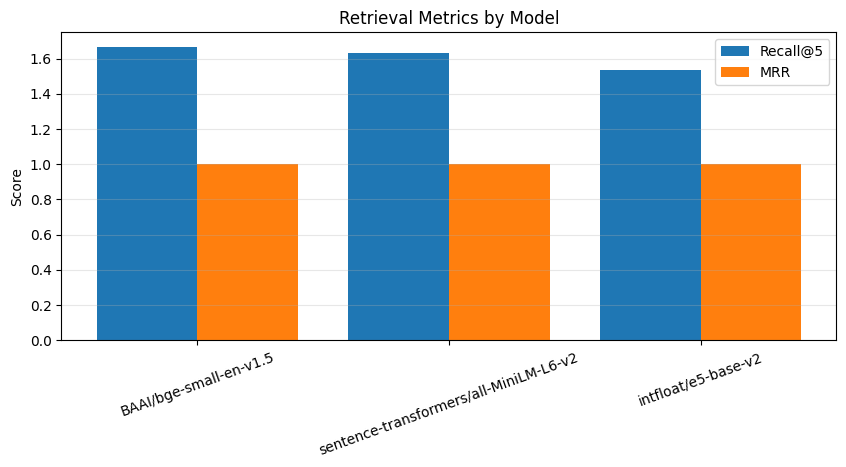

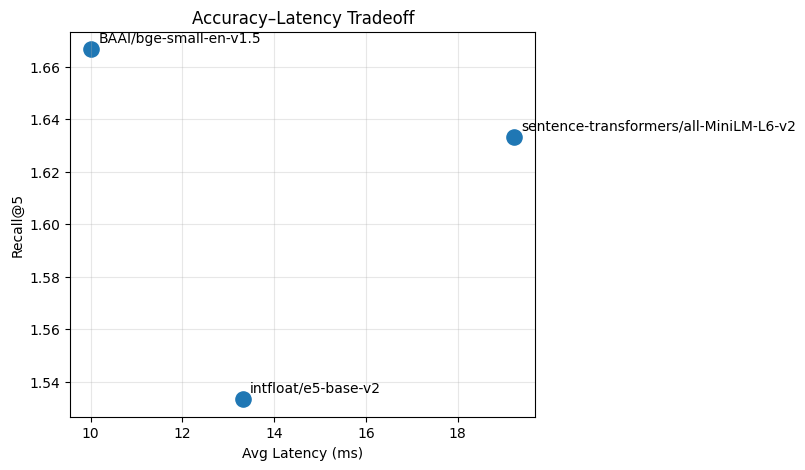

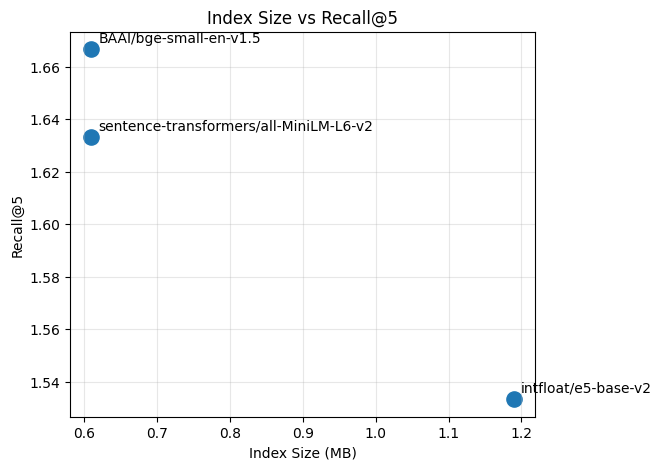


MODEL RECOMMENDATIONS
Production (balanced): BAAI/bge-small-en-v1.5  — Score 0.700
Quality-focused      : BAAI/bge-small-en-v1.5  — Score 0.600
Speed-focused        : BAAI/bge-small-en-v1.5   — Score 1.000

Saved comparison table -> /content/embedding_models_comparison.json


In [30]:
# =============================================================================
# EMBEDDING MODELS COMPARISON, VISUALIZATION & RECOMMENDATION
# =============================================================================
import os, json, math
import numpy as np
import pandas as pd
from pathlib import Path

# Expects: `model_evaluation_results` from your retrieval-eval cell, e.g.:
# model_evaluation_results[model_key] = {
#   "recall_at_k", "mrr", "avg_latency_ms", "num_queries",
#   "embeddings_size_mb", "avg_embedding_time_ms",
#   "model_size_mb", "embedding_dimension", "index_size_mb"
# }

# ---- Robust model size (MB) if missing: try HF cache + in-memory params fallback ----
def approx_model_size_mb_from_params(model) -> float:
    total = 0
    for p in model.get_sentence_embedding_dimension(),:
        pass  # placeholder to keep transformers import-free here
    # more robust: sum of all parameter tensors if accessible
    try:
        params = 0
        bytes_total = 0
        # sentence-transformers exposes modules under ._first_module()
        m = model._first_module()
        for p in m.parameters():
            params += p.numel()
            bytes_total += p.numel() * (4 if p.dtype in (torch.float32, torch.int32) else 2)
        return round(bytes_total / (1024*1024), 2)
    except Exception:
        return None

def try_fill_model_sizes(model_evaluation_results, embedding_models):
    for mk, v in model_evaluation_results.items():
        if v.get("model_size_mb") not in (None, np.nan):
            continue
        # Try cache folder size
        est = None
        try:
            m = embedding_models.get(mk, None)
            if m is not None and hasattr(m, "cache_folder"):
                cache_dir = Path(m.cache_folder)
                if cache_dir.exists():
                    sz = 0
                    for p in cache_dir.rglob("*"):
                        if p.is_file(): sz += p.stat().st_size
                    est = round(sz/(1024*1024), 2)
        except Exception:
            est = None
        # Fallback to parameter-size estimate
        if est is None:
            try:
                m = embedding_models.get(mk, None)
                if m is not None:
                    est = approx_model_size_mb_from_params(m)
            except Exception:
                est = None
        model_evaluation_results[mk]["model_size_mb"] = est

# Fill missing sizes if possible
try_fill_model_sizes(model_evaluation_results, embedding_models)

def create_embedding_comparison_table():
    """Return a ranked comparison DataFrame across models."""
    rows = []
    for mk, met in model_evaluation_results.items():
        rows.append({
            "Model": mk,
            "Recall@5": float(met.get("recall_at_k", 0.0)),
            "MRR": float(met.get("mrr", 0.0)),
            "Avg Latency (ms)": float(met.get("avg_latency_ms", 0.0)),
            "Index Size (MB)": float(met.get("index_size_mb") or 0.0),
            "Embeddings Size (MB)": float(met.get("embeddings_size_mb") or 0.0),
            "Avg Time/Embed (ms)": float(met.get("avg_embedding_time_ms") or 0.0),
            "Model Size (MB)": model_evaluation_results[mk].get("model_size_mb"),
            "Embedding Dim": int(met.get("embedding_dimension", 0)),
            "Num Queries": int(met.get("num_queries", 0)),
        })
    df = pd.DataFrame(rows)
    return df.sort_values(["Recall@5","MRR","Avg Latency (ms)"], ascending=[False, False, True]).reset_index(drop=True)

comp_df = create_embedding_comparison_table()
display(comp_df)

# ---- Visualizations ----
import matplotlib.pyplot as plt

# 1) Recall@5 & MRR bars
plt.figure(figsize=(10,4))
x = np.arange(len(comp_df))
plt.bar(x-0.2, comp_df["Recall@5"], width=0.4, label="Recall@5")
plt.bar(x+0.2, comp_df["MRR"], width=0.4, label="MRR")
plt.xticks(x, comp_df["Model"], rotation=20)
plt.ylabel("Score")
plt.title("Retrieval Metrics by Model")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()

# 2) Latency vs Recall@5 scatter
plt.figure(figsize=(6,5))
plt.scatter(comp_df["Avg Latency (ms)"], comp_df["Recall@5"], s=120)
for i, row in comp_df.iterrows():
    plt.annotate(row["Model"], (row["Avg Latency (ms)"], row["Recall@5"]), xytext=(5,5), textcoords="offset points")
plt.xlabel("Avg Latency (ms)")
plt.ylabel("Recall@5")
plt.title("Accuracy–Latency Tradeoff")
plt.grid(alpha=0.3)
plt.show()

# 3) Index size vs Recall@5 scatter (if index size available)
if comp_df["Index Size (MB)"].sum() > 0:
    plt.figure(figsize=(6,5))
    plt.scatter(comp_df["Index Size (MB)"], comp_df["Recall@5"], s=120)
    for i, row in comp_df.iterrows():
        plt.annotate(row["Model"], (row["Index Size (MB)"], row["Recall@5"]), xytext=(5,5), textcoords="offset points")
    plt.xlabel("Index Size (MB)")
    plt.ylabel("Recall@5")
    plt.title("Index Size vs Recall@5")
    plt.grid(alpha=0.3)
    plt.show()

# ---- Recommendation (balanced, quality-focused, speed-focused) ----
def recommend_models(df: pd.DataFrame):
    # Normalize helper (higher=better)
    def norm_hi(series):
        s = series.astype(float)
        mn, mx = s.min(), s.max()
        return (s - mn) / max(1e-9, (mx - mn))

    # For latency & index size: lower is better → invert
    def norm_lo(series):
        return 1.0 - norm_hi(series)

    recall = norm_hi(df["Recall@5"])
    mrr    = norm_hi(df["MRR"])
    lat    = norm_lo(df["Avg Latency (ms)"])
    idxsz  = norm_lo(df["Index Size (MB)"] if "Index Size (MB)" in df else pd.Series([0]*len(df)))

    production_score = 0.4*recall + 0.3*mrr + 0.2*lat + 0.1*idxsz
    quality_score    = 0.5*recall + 0.4*mrr + 0.1*lat
    speed_score      = 0.5*lat + 0.3*recall + 0.2*idxsz

    rec = df.copy()
    rec["Production Score"] = production_score
    rec["Quality Score"] = quality_score
    rec["Speed Score"] = speed_score

    # Top-1 for each scenario
    prod_best = rec.sort_values("Production Score", ascending=False).iloc[0]
    qual_best = rec.sort_values("Quality Score",    ascending=False).iloc[0]
    spd_best  = rec.sort_values("Speed Score",      ascending=False).iloc[0]

    print("\nMODEL RECOMMENDATIONS")
    print("="*60)
    print(f"Production (balanced): {prod_best['Model']}  — Score {prod_best['Production Score']:.3f}")
    print(f"Quality-focused      : {qual_best['Model']}  — Score {qual_best['Quality Score']:.3f}")
    print(f"Speed-focused        : {spd_best['Model']}   — Score {spd_best['Speed Score']:.3f}")

    return rec.sort_values("Production Score", ascending=False)

ranked = recommend_models(comp_df)

# Save artifacts for your report
out_json = "/content/embedding_models_comparison.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(comp_df.to_dict(orient="records"), f, indent=2)
print(f"\nSaved comparison table -> {out_json}")

In [31]:
    import shutil
    import os
    from google.colab import files

    folder_to_download = "/content/indexes"  # Replace with the actual folder name
    output_zip_name = f"{folder_to_download}.zip"

    # Create the zip archive
    shutil.make_archive(folder_to_download, 'zip', folder_to_download)

'/content/indexes.zip'